In [45]:
# ✈️ Airline Ancillary Revenue Prediction - Hybrid Pipeline

# 📌 Model 1: Binary Classification - Will a customer buy ANY ancillary product?

# 🎯 Step 1: Import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (classification_report, confusion_matrix,
                             roc_auc_score, roc_curve, accuracy_score)

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier


import warnings
warnings.filterwarnings("ignore")

In [46]:
# 🎯 Step 2: Load and prepare data
df = pd.read_csv("Airlines_Ancilliary_Revenue_Data_Kaggle_V6.csv")

# Define target: Any Ancillary Buyer
target_cols = ['Travel_Insurance', 'wants_preferred_seat', 'Extra_Baggage', 
               'Meal', 'Priority_Boarding', 'Premium_Lounge']
df['Ancillary_Buyer'] = df[target_cols].any(axis=1).astype(int)

# Store and remove Customer_ID from feature set
customer_ids = df['Customer_ID']
df.drop(columns=['Customer_ID'], inplace=True)


In [47]:
print("Available columns:", df.columns.tolist())
df.head()

Available columns: ['Age', 'Gender', 'Family_Size', 'Num_Adults', 'Num_Children', 'Device_Type', 'Has_Return_Flight', 'Is_Multi_City', 'Booking_Lead_Time', 'length_of_stay', 'Trip_Duration', 'flight_day', 'Destination', 'Origin', 'Extra_Baggage', 'wants_preferred_seat', 'Meal', 'Travel_Insurance', 'Priority_Boarding', 'Premium_Lounge', 'flight_duration', 'booking_complete', 'Previous_Ancillary_Purchases', 'Recency_Days', 'Booking_Frequency', 'Session_Duration', 'Page_Views', 'Ancillary_Buyer']


,Age,Gender,Family_Size,Num_Adults,Num_Children,Device_Type,Has_Return_Flight,Is_Multi_City,Booking_Lead_Time,length_of_stay,...,Priority_Boarding,Premium_Lounge,flight_duration,booking_complete,Previous_Ancillary_Purchases,Recency_Days,Booking_Frequency,Session_Duration,Page_Views,Ancillary_Buyer
0,56,Female,6,2,4,Website,RoundTrip,0,262,19,...,0,0,5.52,0,0,156,3,245,6,1
1,69,Male,3,1,2,Website,RoundTrip,0,112,20,...,0,0,5.52,0,0,224,1,478,6,0
2,46,Male,5,2,3,Website,RoundTrip,0,243,22,...,0,0,5.52,0,1,154,4,366,4,1
3,32,Female,1,1,0,Website,RoundTrip,0,96,31,...,1,0,5.52,0,1,352,3,199,2,1
4,60,Male,3,2,1,Website,RoundTrip,0,68,22,...,0,0,5.52,0,1,73,1,393,8,1


In [48]:
# 🎯 Step 3: Feature and target separation
# Clean data types BEFORE defining X and y

# Known numeric columns to fix
numeric_candidates = [
    'Age', 'Family_Size', 'Num_Adults', 'Num_Children',
    'Booking_Lead_Time', 'length_of_stay', 'Trip_Duration', 'flight_duration',
    'Previous_Ancillary_Purchases', 'Recency_Days', 'Booking_Frequency',
    'Session_Duration', 'Page_Views', 'booking_complete'
]

# Force convert to numeric
for col in numeric_candidates:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Fill NaNs with median
df[numeric_candidates] = df[numeric_candidates].fillna(df[numeric_candidates].median())

# ✅ Define feature matrix and target
X = df.drop(columns=target_cols + ['Ancillary_Buyer', 'Customer_ID'], errors='ignore')
y = df['Ancillary_Buyer']

# Final feature type separation based on actual data
numeric_features = [col for col in numeric_candidates if col in X.columns]
categorical_features = X.select_dtypes(include=['object', 'bool', 'category']).columns.tolist()

# ✅ Build preprocessor
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_features)
])


In [49]:
print("🧠 Final numeric features:", numeric_features)
print("🧠 Final categorical features:", categorical_features)
print("🧠 Any object types left in X?", X.select_dtypes(include='object').columns.tolist())


🧠 Final numeric features: ['Age', 'Family_Size', 'Num_Adults', 'Num_Children', 'Booking_Lead_Time', 'length_of_stay', 'Trip_Duration', 'flight_duration', 'Previous_Ancillary_Purchases', 'Recency_Days', 'Booking_Frequency', 'Session_Duration', 'Page_Views', 'booking_complete']
🧠 Final categorical features: ['Gender', 'Device_Type', 'Has_Return_Flight', 'flight_day', 'Destination', 'Origin']
🧠 Any object types left in X? ['Gender', 'Device_Type', 'Has_Return_Flight', 'flight_day', 'Destination', 'Origin']


In [51]:
# 🎯 Step 4: Train-Validation-Test split
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp)  # 60/20/20 split

In [52]:
try:
    preprocessor.fit(X_train)
    X_transformed = preprocessor.transform(X_train)
    print("✅ Preprocessing succeeded. Shape:", X_transformed.shape)

except Exception as e:
    print("❌ Preprocessing failed.")
    print("Error:", e)

✅ Preprocessing succeeded. Shape: (30000, 875)


In [53]:
print("🔍 Data types before preprocessing:")
print(df.dtypes)

🔍 Data types before preprocessing:
Age                               int64
Gender                           object
Family_Size                       int64
Num_Adults                        int64
Num_Children                      int64
Device_Type                      object
Has_Return_Flight                object
Is_Multi_City                     int64
Booking_Lead_Time                 int64
length_of_stay                    int64
Trip_Duration                     int64
flight_day                       object
Destination                      object
Origin                           object
Extra_Baggage                     int64
wants_preferred_seat              int64
Meal                              int64
Travel_Insurance                  int64
Priority_Boarding                 int64
Premium_Lounge                    int64
flight_duration                 float64
booking_complete                  int64
Previous_Ancillary_Purchases      int64
Recency_Days                      int64
Booki

In [54]:
# 🚨 Check for any object columns that snuck in
print("🧪 Columns passed to model (X_train):", X_train.columns.tolist())
print("🧪 Data types of X_train:")
print(X_train.dtypes)

# Bonus: Check for remaining NaNs
print("🧪 NaNs in X_train:\n", X_train.isnull().sum())

🧪 Columns passed to model (X_train): ['Age', 'Gender', 'Family_Size', 'Num_Adults', 'Num_Children', 'Device_Type', 'Has_Return_Flight', 'Is_Multi_City', 'Booking_Lead_Time', 'length_of_stay', 'Trip_Duration', 'flight_day', 'Destination', 'Origin', 'flight_duration', 'booking_complete', 'Previous_Ancillary_Purchases', 'Recency_Days', 'Booking_Frequency', 'Session_Duration', 'Page_Views']
🧪 Data types of X_train:
Age                               int64
Gender                           object
Family_Size                       int64
Num_Adults                        int64
Num_Children                      int64
Device_Type                      object
Has_Return_Flight                object
Is_Multi_City                     int64
Booking_Lead_Time                 int64
length_of_stay                    int64
Trip_Duration                     int64
flight_day                       object
Destination                      object
Origin                           object
flight_duration          

In [55]:
# 🎯 Step 6: Define models for comparison
models = {
    'RandomForest': RandomForestClassifier(random_state=42),
    'LogisticRegression': LogisticRegression(max_iter=1000),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

best_model = None
best_auc = 0
best_name = ""

print("\n📊 Model Evaluation Summary:\n")

for name, model in models.items():
    pipe = Pipeline([
        ('preprocess', preprocessor),
        ('clf', model)
    ])
    pipe.fit(X_train, y_train)
    val_probs = pipe.predict_proba(X_val)[:, 1]
    val_preds = pipe.predict(X_val)
    auc = roc_auc_score(y_val, val_probs)
    print(f"{name} AUC: {auc:.4f}")
    print(classification_report(y_val, val_preds))
    
    if auc > best_auc:
        best_model = pipe
        best_auc = auc
        best_name = name


📊 Model Evaluation Summary:

RandomForest AUC: 0.6543
              precision    recall  f1-score   support

           0       0.67      0.00      0.00      1271
           1       0.87      1.00      0.93      8729

    accuracy                           0.87     10000
   macro avg       0.77      0.50      0.47     10000
weighted avg       0.85      0.87      0.81     10000

LogisticRegression AUC: 0.6473
              precision    recall  f1-score   support

           0       0.83      0.00      0.01      1271
           1       0.87      1.00      0.93      8729

    accuracy                           0.87     10000
   macro avg       0.85      0.50      0.47     10000
weighted avg       0.87      0.87      0.81     10000

XGBoost AUC: 0.6561
              precision    recall  f1-score   support

           0       0.34      0.02      0.03      1271
           1       0.87      1.00      0.93      8729

    accuracy                           0.87     10000
   macro avg       0.6

In [56]:
# 🎯 Step 7: Evaluate best model on test set
y_test_pred = best_model.predict(X_test)
y_test_proba = best_model.predict_proba(X_test)[:, 1]

print("\n✅ Best Model:", best_name)
print("Confusion Matrix (Test):")
print(confusion_matrix(y_test, y_test_pred))
print("Classification Report (Test):")
print(classification_report(y_test, y_test_pred))
print("ROC AUC (Test):", roc_auc_score(y_test, y_test_proba))


✅ Best Model: XGBoost
Confusion Matrix (Test):
[[  20 1252]
 [  42 8686]]
Classification Report (Test):
              precision    recall  f1-score   support

           0       0.32      0.02      0.03      1272
           1       0.87      1.00      0.93      8728

    accuracy                           0.87     10000
   macro avg       0.60      0.51      0.48     10000
weighted avg       0.80      0.87      0.82     10000

ROC AUC (Test): 0.6812419474084707


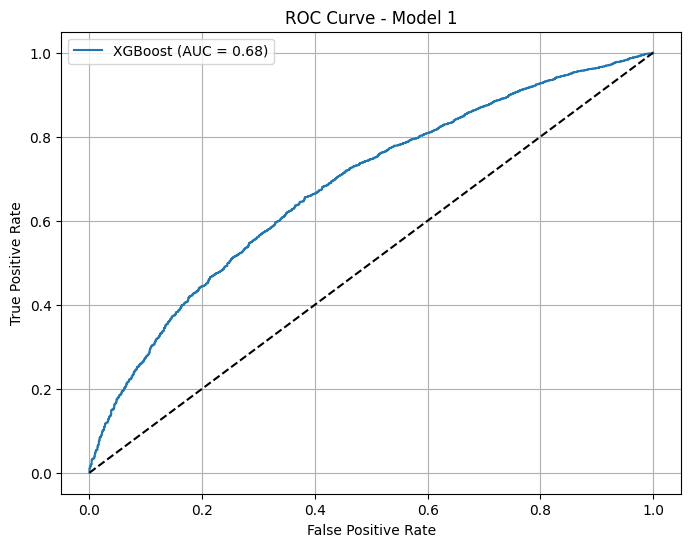

In [57]:
# 🎯 Step 8: Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_test_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'{best_name} (AUC = {roc_auc_score(y_test, y_test_proba):.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Model 1')
plt.legend()
plt.grid(True)
plt.show()

In [41]:
# 🎯 Step 9: Save Model 1 Predictions
#X_test_reset = X_test.reset_index(drop=True)
#X_test_reset = X_test.reset_index(drop=True)
#model1_output = pd.DataFrame({
#    'Customer_ID': customer_ids.loc[X_test.index].values,
#    'Ancillary_Buyer_Prediction': np.where(y_test_proba >= 0.5, 'Likely', 'Unlikely'),
#    'Ancillary_Buyer_Probability': y_test_proba
#})

#model1_output.to_csv("model1_any_ancillary_prediction.csv", index=False)
#model1_output.head()
#print("\n✅ Model 1 predictions saved to 'model1_any_ancillary_prediction.csv'")

In [59]:
# 🎯 Step 9: Model 1 - Full Prediction for All Customers
# Predict on the full dataset (X, not just test set)
y_all_proba = best_model.predict_proba(X)[:, 1]
df['Ancillary_Buyer_Probability'] = y_all_proba
df['Ancillary_Buyer_Prediction'] = np.where(y_all_proba >= 0.5, 'Likely', 'Unlikely')

# 🔄 Save full output for business reporting
model1_full = pd.DataFrame({
    'Customer_ID': customer_ids.values,
    'Ancillary_Buyer_Probability': y_all_proba,
    'Ancillary_Buyer_Prediction': np.where(y_all_proba >= 0.5, 'Likely', 'Unlikely')
})
model1_full.to_csv("model1_full_predictions.csv", index=False)
print("✅ Full predictions saved to model1_full_predictions.csv")

# 🔄 Save only likely customers for Model 2 input
model1_likely = model1_full[model1_full['Ancillary_Buyer_Prediction'] == 'Likely']
model1_likely.to_csv("model1_likely_customers.csv", index=False)
print("✅ Likely customers saved to model1_likely_customers.csv")

✅ Full predictions saved to model1_full_predictions.csv
✅ Likely customers saved to model1_likely_customers.csv


In [61]:
# 📌 Model 2: Product Affinity Prediction for 'Likely' Customers Only
# 🎯 Step 10: Filter 'Likely' customers
df['Customer_ID'] = customer_ids  # restore ID
likely_customers = model1_full[model1_full['Ancillary_Buyer_Prediction'] == 'Likely']
likely_df = df[df['Customer_ID'].isin(likely_customers['Customer_ID'])].copy()

In [62]:
print(likely_df['Travel_Insurance'].value_counts())

Travel_Insurance
0    39641
1     9935
Name: count, dtype: int64


In [63]:
print("Final check on X_train:")
print(X_train.dtypes)

Final check on X_train:
Age                               int64
Gender                           object
Family_Size                       int64
Num_Adults                        int64
Num_Children                      int64
Device_Type                      object
Has_Return_Flight                object
Is_Multi_City                     int64
Booking_Lead_Time                 int64
length_of_stay                    int64
Trip_Duration                     int64
flight_day                       object
Destination                      object
Origin                           object
flight_duration                 float64
booking_complete                  int64
Previous_Ancillary_Purchases      int64
Recency_Days                      int64
Booking_Frequency                 int64
Session_Duration                  int64
Page_Views                        int64
dtype: object


In [69]:
model1_output = pd.read_csv("model1_full_predictions.csv")  # <- make sure it's this file
likely_customers = model1_output[model1_output['Ancillary_Buyer_Prediction'] == 'Likely']
print("✅ Total customers in full dataset:", df.shape[0])
print("✅ Likely customers in Model 1:", likely_customers.shape[0])
print("✅ Rows in likely_df (Model 2 input):", likely_df.shape[0])

✅ Total customers in full dataset: 50000
✅ Likely customers in Model 1: 49576
✅ Rows in likely_df (Model 2 input): 49576


In [65]:
# 🎯 Step 11: Create product-level models
affinity_results = likely_df[['Customer_ID']].copy()

for product in target_cols:
    print(f"\n🔍 Training model for: {product}")
    
    X_prod = likely_df.drop(columns=target_cols + ['Ancillary_Buyer', 'Customer_ID'])
    y_prod = likely_df[product]

    X_train_p, X_test_p, y_train_p, y_test_p = train_test_split(
        X_prod, y_prod, test_size=0.2, random_state=42, stratify=y_prod
    )

    final_pipe = Pipeline([
        ('preprocess', preprocessor),
        ('clf', RandomForestClassifier(random_state=42))
    ])

    # Train the model
    final_pipe.fit(X_train_p, y_train_p)

    # Predict probabilities
    #y_prob = final_pipe.predict_proba(X_test_p)[:, 1]

    # Segment labels
    def assign_segment(p):
        if p > 0.8: return f"{product} Enthusiast"
        elif p > 0.6: return f"{product} Upsellable"
        elif p > 0.3: return f"{product} Persuadable"
        else: return f"{product} Unlikely"

    # Create product result set
    #product_results = pd.DataFrame({
    #   'Customer_ID': likely_df.loc[X_test_p.index, 'Customer_ID'].values,
    #    product + '_Score': y_prob,
    #    product + '_Segment': [assign_segment(p) for p in y_prob]
    #})
    y_prob = final_pipe.predict_proba(X_prod)[:, 1]  # Score all likely customers

    product_results = pd.DataFrame({
        'Customer_ID': likely_df['Customer_ID'].values,
        product + '_Score': y_prob,
        product + '_Segment': [assign_segment(p) for p in y_prob]
})
    # Merge with overall result set
    affinity_results = affinity_results.merge(product_results, on='Customer_ID', how='left')



🔍 Training model for: Travel_Insurance

🔍 Training model for: wants_preferred_seat

🔍 Training model for: Extra_Baggage

🔍 Training model for: Meal

🔍 Training model for: Priority_Boarding

🔍 Training model for: Premium_Lounge


In [66]:
print("🔍 Unique likely customers:", likely_df['Customer_ID'].nunique())
print("🔍 Customer_IDs in current product result:", product_results['Customer_ID'].nunique())
print("🔍 Rows in product result:", product_results.shape[0])

🔍 Unique likely customers: 49576
🔍 Customer_IDs in current product result: 49576
🔍 Rows in product result: 49576


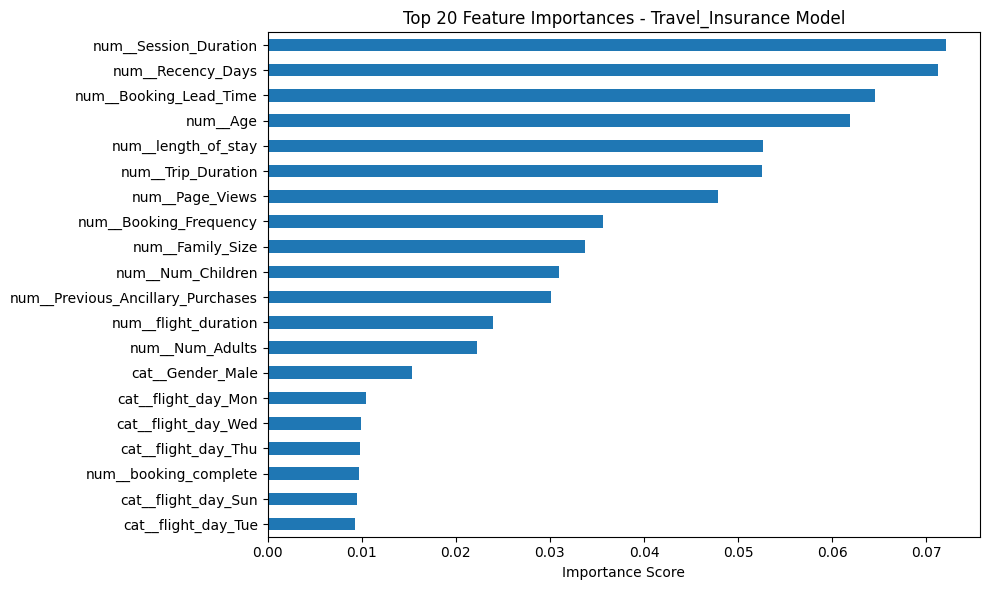

In [73]:
# 🎯 Step 12: Feature Importance Plot
importances = final_pipe.named_steps['clf'].feature_importances_
features = final_pipe.named_steps['preprocess'].get_feature_names_out()

# Create a sorted feature importance DataFrame
feat_imp = pd.Series(importances, index=features).sort_values(ascending=False)

# Plot top 20 features
plt.figure(figsize=(10, 6))
feat_imp.head(20).plot(kind='barh')
plt.gca().invert_yaxis()
plt.title("Top 20 Feature Importances - Travel_Insurance Model")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()

In [71]:
# 🎯 Step 13: Export Model 2 Results
affinity_results.to_csv("model2_product_affinity_scores_and_segments.csv", index=False)
print("\n✅ Model 2 predictions saved to 'model2_product_affinity_scores_and_segments.csv'")



✅ Model 2 predictions saved to 'model2_product_affinity_scores_and_segments.csv'
